In [1]:
import numpy as onp
import jax.numpy as np

from jax import lax, random
from jax.api import grad, jit, vmap
from jax.config import config
from jax.experimental import optimizers

config.update('jax_enable_x64', True)

from functools import partial
from jax import random

from neural_tangents import stax

# Attacking
from jax.experimental.stax import logsoftmax
from cleverhans.utils import clip_eta, one_hot

# Plotting
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import *
sns.set_style(style='white')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

"""
diag_reg:
    a scalar representing the strength of the diagonal regularization for
    `k_train_train`, i.e. computing `k_train_train + diag_reg * I` during
    Cholesky factorization or eigendecomposition.
"""
diag_reg = 1e-4
batch_size = 30

In [8]:
x_train_all, y_train_all, x_test, y_test = tuple(np.array(x) for x in get_dataset('mnist', None, None, 
                                                                                  do_flatten_and_normalize=False))

In [9]:
seed = 0
x_train_all, y_train_all = shaffle(x_train_all, y_train_all, seed)

In [10]:
train_size = 256
x_train = x_train_all[:train_size]
y_train = y_train_all[:train_size]
shape = (x_train.shape[0], 32, 32, 1)

## Objective - Matrix

In [7]:
def accuracy(mean, ys):
    return np.mean(np.argmax(mean, axis=-1) == np.argmax(ys, axis=-1))

In [8]:
def DenseBlock(neurons, W_std, b_std):
    return stax.serial(stax.Dense(neurons, W_std, b_std), 
                       stax.Erf())

def DenseGroup(n, neurons, W_std, b_std):
    blocks = []
    for _ in range(n):
        blocks += [DenseBlock(neurons, W_std, b_std)]
    return stax.serial(*blocks)

In [9]:
# b = 0.05
b = 0.18
W = [1., 1.76, 2.5]
phase_list = ['Ordered', 'Critical', 'Chaotic']
layers = np.arange(19, 100, 20)
layer = 5
num_classes = 10

kernel_list = []
fx_train_0_list = []
fx_test_0_list = []

key = random.PRNGKey(0)

b_std = np.sqrt(b)
for w in W:
    W_std = np.sqrt(w)

    init_fn, apply_fn, kernel_fn = stax.serial(DenseGroup(layer, 1024, W_std, b_std))
    
    # Inference with a single infinite width / linearized network
    apply_fn = jit(apply_fn)
    kernel_fn = jit(kernel_fn, static_argnums=(2,))
    kernel_list.append(kernel_fn)

In [10]:
def model_fn(kernel_fn, obj_fn, x_train=None, x_test=None, fx_train_0=0., fx_test_0=0., t=None):
    # Kernel
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    
    if obj_fn == 'train':
        return ntk_train_train
    elif obj_fn == 'test':
        ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
        # Prediction
        predict_fn = nt.predict.gradient_descent_mse(ntk_train_train, y_train, diag_reg=diag_reg) # no convariance
        return predict_fn(t, fx_train_0, fx_test_0, ntk_test_train) # fx_train_0, fx_test_0 = (0, 0) for infinite width
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

In [11]:
@jit
def l2_loss_v1(logits, labels, weighting=1):
    """
    Tensorflow version of L2 loss (without sqrt)
    """
    return np.sum(((logits - labels)**2) * weighting) / 2
    
@jit
def l2_loss_v2(logits, lables):
    """
    Normal L2 loss
    """
    return np.linalg.norm(logits - labels)

@jit
def cross_entropy_loss(logits, lables):
    return -np.sum(logsoftmax(logits) * lables)
    
@jit
def mse_loss(logits, lables):
    return 0.5 * np.mean((logits - lables) ** 2)

In [12]:
def train_loss_adv(x_train, y, kernel_fn, weighting):
    # Compute NTK on training data
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    loss = - l2_loss_v1(ntk_train_train, y, weighting) # y = matrix of 1 / diagnal
    return loss

# train_grads_fn = grad(train_loss_adv)
train_grads_fn = jit(grad(train_loss_adv), static_argnums=(2,)) # static arg: expanding {if / else} loops for graph mode

In [11]:
def test_loss_adv(x_train, x_test, kernel_fn, c, t=None):
    # Kernel
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
    
    # Θ(test, train)Θ(train, train)^-1
    def inv(k):
        #inverse with diag_reg
        return np.linalg.inv(k + diag_reg * np.eye(k.shape[0]))
    
    mean_predictor = np.einsum('ij,jk->ik', ntk_test_train, inv(ntk_train_train))
    
    # Loss
    loss = - l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c)
    return loss

# test_grads_fn = grad(test_loss_adv, argnums=0)
# test_c_grads_fn = grad(test_loss_adv, argnums=3)
test_grads_fn = jit(grad(test_loss_adv, argnums=0), static_argnums=(2,))
test_c_grads_fn = jit(grad(test_loss_adv, argnums=3), static_argnums=(2,))

In [12]:
def test_pred_loss_adv(x_train, x_test, y_train, y, kernel_fn, loss='mse', t=None):
    # Kernel
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
    
    # Prediction
    predict_fn = nt.predict.gradient_descent_mse(ntk_train_train, y_train, diag_reg=diag_reg) # diag_reg: add to easier inverse
    fx = predict_fn(t, 0., 0., ntk_test_train)[1]
    
    # Loss
    if loss == 'cross-entropy':
        loss = cross_entropy_loss(fx, y)
    elif loss == 'mse':
        loss = mse_loss(fx, y)
    return loss

test_pred_grads_fn = jit(grad(test_pred_loss_adv, argnums=0), static_argnums=(4, 5))

In [23]:
def fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn=None, x_train=None, y_train=None, x_test=None, 
                         y=None, t=None, c=None, update_c=False, loss='cross-entropy', loss_weighting=None, phase=None, 
                         fx_train_0=0., fx_test_0=0., eps=0.3, norm=np.inf, clip_min=None, clip_max=None, targeted=False):
    """
    JAX implementation of the Fast Gradient Method.
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
    :param norm: Order of the norm (mimics NumPy). Possible values: np.inf or 2.
    :param clip_min: (optional) float. Minimum float value for adversarial example components.
    :param clip_max: (optional) float. Maximum float value for adversarial example components.
    :param y: (optional) Tensor with one-hot true labels. If targeted is true, then provide the
            target one-hot label. Otherwise, only provide this parameter if you'd like to use true
            labels when crafting adversarial samples. Otherwise, model predictions are used
            as labels to avoid the "label leaking" effect (explained in this paper:
            https://arxiv.org/abs/1611.01236). Default is None. This argument does not have
            to be a binary one-hot label (e.g., [0, 1, 0, 0]), it can be floating points values
            that sum up to 1 (e.g., [0.05, 0.85, 0.05, 0.05]).
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
            Untargeted, the default, will try to make the label incorrect.
            Targeted will instead try to move in the direction of being more like y.
    :return: a tensor for the adversarial example
    """
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    x = x_train
    if obj_fn == 'test':
        if y is None:
            # Using model predictions as ground truth to avoid label leaking
            x_labels = np.argmax(model_fn(kernel_fn, 'test', x_train, x_test, fx_train_0, fx_test_0)[1], 1)
            y = one_hot(x_labels, 10)
    elif obj_fn == 'train':
        if y is None:
            # Compute NTK on training data
            ntk_train_train = model_fn(kernel_fn=kernel_fn, obj_fn='train', x_train=x_train)
            
            # Construct diagonal
            if phase == 'ordered':
                y = np.ones(ntk_train_train.shape)*100
            elif phase == 'chaotic':
                y = np.eye(ntk_train_train.shape[0])*100
            else:
                raise ValueError("Phase must be either 'ordered' or 'critical'")
        
    # Obj - Θ(train, train)
    if obj_fn == 'train':
        grads = grads_fn(x_train, y, kernel_fn, loss_weighting)
        
    # Obj - Θ(test, train)Θ(train, train)^-1
    elif obj_fn == 'test_c':
        grads = 0
        grads_c = 0
        for i in range(int(len(x_test)/batch_size)):
            grads += grads_fn(x_train, x_test[batch_size*i:batch_size*(i+1)], kernel_fn, c, t)
            if update_c is True:
                grads_c += grads_c_fn(x_train, x_test[batch_size*i:batch_size*(i+1)], kernel_fn, c, t)
        grads_c = 3e-6 * np.sign(grads_c)
#         grads_c = 5e-2 * np.sign(grads_c)
        
    # Obj - Θ(test, train)Θ(train, train)^-1 y_train
    elif obj_fn == 'test':
        grads = 0
        for i in range(int(len(x_test)/batch_size)):
            batch_grads = grads_fn(x_train, 
                                   x_test[batch_size*i:batch_size*(i+1)], 
                                   y_train, 
                                   y[batch_size*i:batch_size*(i+1)], 
                                   kernel_fn, 
                                   loss,
                                   t)
            grads += batch_grads
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

    axis = list(range(1, len(grads.shape)))
    avoid_zero_div = 1e-12
    if norm == np.inf:
        perturbation = eps * np.sign(grads)
    elif norm == 1:
        raise NotImplementedError("L_1 norm has not been implemented yet.")
    elif norm == 2:
        square = np.maximum(avoid_zero_div, np.sum(np.square(grads), axis=axis, keepdims=True))
        perturbation = grads / np.sqrt(square)
    
    adv_x = x + perturbation
    
    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) or (clip_max is not None):
        # We don't currently support one-sided clipping
        assert clip_min is not None and clip_max is not None
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
    
    if obj_fn == 'test_c':
        c += grads_c
        return adv_x, c
    return adv_x

In [14]:
def projected_gradient_descent(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn=None, x_train=None, y_train=None,
                               x_test=None, y=None, t=None, c=None, update_c=None, loss='cross-entropy', loss_weighting=None, 
                               phase=None, fx_train_0=0., fx_test_0=0., eps=0.3, eps_iter=0.03, nb_iter=10, norm=np.inf, 
                               clip_min=None, clip_max=None, targeted=False, rand_init=None, rand_minmax=0.3):
    """
    This class implements either the Basic Iterative Method
    (Kurakin et al. 2016) when rand_init is set to 0. or the
    Madry et al. (2017) method when rand_minmax is larger than 0.
    Paper link (Kurakin et al. 2016): https://arxiv.org/pdf/1607.02533.pdf
    Paper link (Madry et al. 2017): https://arxiv.org/pdf/1706.06083.pdf
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
    :param eps_iter: step size for each attack iteration
    :param nb_iter: Number of attack iterations.
    :param norm: Order of the norm (mimics NumPy). Possible values: np.inf or 2.
    :param clip_min: (optional) float. Minimum float value for adversarial example components.
    :param clip_max: (optional) float. Maximum float value for adversarial example components.
    :param y: (optional) Tensor with true labels. If targeted is true, then provide the
            target label. Otherwise, only provide this parameter if you'd like to use true
            labels when crafting adversarial samples. Otherwise, model predictions are used
            as labels to avoid the "label leaking" effect (explained in this paper:
            https://arxiv.org/abs/1611.01236). Default is None.
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
            Untargeted, the default, will try to make the label incorrect.
            Targeted will instead try to move in the direction of being more like y.
    :return: a tensor for the adversarial example
    """

    assert eps_iter <= eps, (eps_iter, eps)
    if norm == 1:
        raise NotImplementedError("It's not clear that FGM is a good inner loop"
                                  " step for PGD when norm=1, because norm=1 FGM "
                                  " changes only one pixel at a time. We need "
                                  " to rigorously test a strong norm=1 PGD "
                                  "before enabling this feature.")
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    x = x_train
    if obj_fn == 'test':
        if y is None:
            # Using model predictions as ground truth to avoid label leaking
            x_labels = np.argmax(model_fn(kernel_fn, 'test', x_train, x_test, fx_train_0, fx_test_0)[1], 1)
            y = one_hot(x_labels, 10)
    elif obj_fn == 'train':
        if y is None:
            # Compute NTK on training data
            ntk_train_train = model_fn(kernel_fn=kernel_fn, obj_fn='train', x_train=x_train)
            
            # Construct diagonal
            if phase == 'ordered':
                y = np.ones(ntk_train_train.shape)*100
            elif phase == 'chaotic':
                y = np.eye(ntk_train_train.shape[0])*100
            else:
                raise ValueError("Phase must be either 'ordered' or 'critical'")
        
    # Initialize loop variables
    if rand_init:
        rand_minmax = eps
        eta = random.uniform(new_key, x.shape, minval=-rand_minmax, maxval=rand_minmax)
    else:
        eta = np.zeros_like(x)

    # Clip eta
    eta = clip_eta(eta, norm, eps)
    adv_x = x + eta
    if clip_min is not None or clip_max is not None:
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
        
    for i in range(nb_iter):
        if update_c is not None and (i+1) % update_c == 0:
            adv_x = fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn, adv_x, y_train, x_test, 
                                         y, t, c, True, loss, loss_weighting, phase, fx_train_0, fx_test_0, eps_iter, norm, 
                                         clip_min, clip_max, targeted)
        else:
            adv_x = fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn, adv_x, y_train, x_test, 
                                         y, t, c, False, loss, loss_weighting, phase, fx_train_0, fx_test_0, eps_iter, norm, 
                                         clip_min, clip_max, targeted)
        
        if obj_fn == 'test_c':
            adv_x, c = adv_x

        # Clipping perturbation eta to norm norm ball
        eta = adv_x - x
        eta = clip_eta(eta, norm, eps)
        adv_x = x + eta

        # Redo the clipping.
        # FGM already did it, but subtracting and re-adding eta can add some
        # small numerical error.
        if clip_min is not None or clip_max is not None:
            adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)

    if obj_fn == 'test_c':
        return adv_x, c
    return adv_x

In [15]:
# b = 0.05
b = 0.18
W = [1., 1.76, 2.5]
phase_list = ['Ordered', 'Critical', 'Chaotic']
layers = np.arange(19, 100, 20)
layer = 50
num_classes = 10

kernel_list = []
fx_train_0_list = []
fx_test_0_list = []

key = random.PRNGKey(0)

b_std = np.sqrt(b)
for w in W:
    W_std = np.sqrt(w)

    init_fn, apply_fn, kernel_fn = stax.serial(DenseGroup(layer, 1024, W_std, b_std))
    
    # Inference with a single infinite width / linearized network
    apply_fn = jit(apply_fn)
    kernel_fn = jit(kernel_fn, static_argnums=(2,))
    kernel_list.append(kernel_fn)

In [16]:
for idx, kernel_fn in enumerate(kernel_list):
    print(phase_list[idx])
    print(kernel_fn(x_train, x_train, 'ntk')[:4, :4])
    print()

Ordered
[[1.37379235 1.37379195 1.37379177 1.37379194]
 [1.37379195 1.37379236 1.3737918  1.37379179]
 [1.37379177 1.3737918  1.37379235 1.37379195]
 [1.37379194 1.37379179 1.37379195 1.37379234]]

Critical
[[30.82217759 13.98496226 12.30888758 13.81286374]
 [13.98496226 30.91200152 12.64773843 12.66519516]
 [12.30888758 12.64773843 30.75443008 13.79566112]
 [13.81286374 12.66519516 13.79566112 30.68698567]]

Chaotic
[[2.07880683e+04 2.98662443e+00 2.89718017e+00 2.97092652e+00]
 [2.98662443e+00 2.12011832e+04 2.91790614e+00 2.92074674e+00]
 [2.89718017e+00 2.91790614e+00 2.04736293e+04 2.96281474e+00]
 [2.97092652e+00 2.92074674e+00 2.96281474e+00 2.01557097e+04]]



## Attack Hyperparameters

In [17]:
attack_type = ["Clean", "FGSM", "PGD-10", "PGD-100"]

####### MNIST #######
# eps = 0.3
# eps_iter_10 = 0.04
# eps_iter_100 = 0.004
####### MNIST #######

####### CIFAR #######
eps = 16/255
eps_iter_10 = (eps/10)*1.1
eps_iter_100 = (eps/100)*1.1
####### CIFAR #######

val_size = 1200
x_val = x_train_all[train_size:train_size+val_size]
y_val = y_train_all[train_size:train_size+val_size]

## Variance

In [18]:
def mean_predictor(x_train, x_test, kernel_fn, c=None):
    # Kernel
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
    
    # Θ(test, train)Θ(train, train)^-1
    def inv(k):
        return np.linalg.inv(k + diag_reg * np.eye(k.shape[0]))
    mean_predictor = np.einsum('ij,jk->ik', ntk_test_train, inv(ntk_train_train))
    
    if c is None:
        c = np.mean(mean_predictor)
    
    # Loss
    loss = l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c)
    return loss, mean_predictor

In [19]:
for idx, kernel_fn in enumerate(kernel_list):
    l, m = mean_predictor(x_train, x_val, kernel_fn)
    print(phase_list[idx])
    print("Mean: {:.8f}, Loss: {:.8f}".format(np.mean(m), l))
    print(m[:5, :5])
    print()

Ordered
Mean: 0.00390625, Loss: 0.22936214
[[0.00278381 0.00341212 0.0043551  0.00373197 0.00363911]
 [0.00453375 0.00385129 0.00287366 0.00392162 0.00422013]
 [0.00415563 0.00306797 0.00385278 0.00317157 0.00361015]
 [0.00512126 0.00674182 0.00466665 0.00381732 0.00401951]
 [0.00400983 0.00532461 0.00412389 0.00444167 0.00449761]]

Critical
Mean: 0.00387526, Loss: 43.94523938
[[-0.01028681 -0.00859151  0.00626522  0.00538237 -0.0004104 ]
 [ 0.02590303  0.00804861 -0.00252358 -0.00456444  0.01541304]
 [ 0.02432264 -0.01303433  0.00359057 -0.00767022 -0.00457796]
 [ 0.03438266  0.0779383   0.00298547 -0.00184229 -0.00637986]
 [ 0.00085543  0.02853235 -0.00523987  0.01379236  0.03353651]]

Chaotic
Mean: 0.00013465, Loss: 0.00000471
[[0.00013403 0.00013083 0.00013597 0.00013877 0.00013605]
 [0.0001446  0.00013372 0.00013553 0.00014188 0.00014561]
 [0.00013837 0.00013142 0.0001366  0.00013958 0.00013829]
 [0.00014457 0.00014643 0.00013819 0.00014086 0.00014079]
 [0.0001388  0.00013673 0.00

In [25]:
acc_l = []
t = None
c = 0.00387526
loss_type = ['cross-entropy', 'mse']

for _ in range(1):
    x_train_list = []
    c_list = []
    
    x_train_list.append(x_train)
    c_list.append(c)

    # FGSM
    adv_x, c = fast_gradient_method(model_fn=model_fn, kernel_fn=kernel_list[1], obj_fn='test_c', 
                                    grads_fn=test_grads_fn, grads_c_fn=test_c_grads_fn, x_train=x_train, 
                                    y_train=y_train, x_test=x_val, y=y_val, t=t, c=c, loss=loss_type[0], 
                                    eps=eps, clip_min=0, clip_max=1)
    x_train_list.append(adv_x)
    c_list.append(c)
    
    # PGD 10
    key, new_key = random.split(key)
    c = 0.00387526
    adv_x, c = projected_gradient_descent(model_fn=model_fn, kernel_fn=kernel_list[1], obj_fn='test_c', 
                                          grads_fn=test_grads_fn, grads_c_fn=test_c_grads_fn, x_train=x_train, 
                                          y_train=y_train, x_test=x_val, y=y_val, t=t, c=c, update_c=3, 
                                          loss=loss_type[0], eps=eps, eps_iter=eps_iter_10, nb_iter=10, 
                                          clip_min=0, clip_max=1, rand_init=None, rand_minmax=eps)
    x_train_list.append(adv_x)
    c_list.append(c)
    
    # PGD 100
    key, new_key = random.split(key)
    c = 0.00387526
    adv_x, c = projected_gradient_descent(model_fn=model_fn, kernel_fn=kernel_list[1], obj_fn='test_c', 
                                          grads_fn=test_grads_fn, grads_c_fn=test_c_grads_fn, x_train=x_train, 
                                          y_train=y_train, x_test=x_val, y=y_val, t=t, c=c, update_c=3, 
                                          loss=loss_type[0], eps=eps, eps_iter=eps_iter_100, nb_iter=100, 
                                          clip_min=0, clip_max=1, rand_init=None, rand_minmax=eps)
    x_train_list.append(adv_x)
    c_list.append(c)
    
    for idx, _x_train in enumerate(x_train_list):
        _, fx_adv_test_t = model_fn(kernel_list[1], 'test', _x_train, x_test, t=t)
        acc = accuracy(fx_adv_test_t, y_test)
        acc_l.append(acc)
        print("Robustness({:s}): {:.2f}".format(attack_type[idx], acc))
        
        # Mean predictor
        l, m = mean_predictor(_x_train, x_val, kernel_list[1], c_list[idx])
        print("c:{:.8f}, Mean: {:.8f}, Loss: {:.8f}".format(c_list[idx], np.mean(m), l))
        print(m[:5, :5])
        print()

Robustness(Clean): 0.31
c:0.50000000, Mean: 0.00387526, Loss: 37851.01242422
[[-0.01028681 -0.00859151  0.00626522  0.00538237 -0.0004104 ]
 [ 0.02590303  0.00804861 -0.00252358 -0.00456444  0.01541304]
 [ 0.02432264 -0.01303433  0.00359057 -0.00767022 -0.00457796]
 [ 0.03438266  0.0779383   0.00298547 -0.00184229 -0.00637986]
 [ 0.00085543  0.02853235 -0.00523987  0.01379236  0.03353651]]

Robustness(FGSM): 0.31
c:0.50000000, Mean: 0.00392960, Loss: 37830.57984998
[[-0.0108829  -0.00540266  0.00635186  0.00499194 -0.00234042]
 [ 0.02602883  0.00413103 -0.00266    -0.00101752  0.02191871]
 [ 0.02399251 -0.00998711  0.0038191  -0.00327287 -0.00142686]
 [ 0.02957282  0.06139624  0.00413328 -0.00059705  0.00344514]
 [ 0.00442067  0.0200911  -0.00373785  0.01481234  0.03726868]]

Robustness(PGD-10): 0.31
c:0.35000000, Mean: 0.00394025, Loss: 18424.80207198
[[-0.01081628 -0.00651047  0.00602498  0.0047674  -0.00181005]
 [ 0.02572736  0.0039414  -0.0029818  -0.00077654  0.02136189]
 [ 0.0239

In [40]:
t_eval = 64

In [41]:
# t = t_eval
# predict test
for idx, _x_train in enumerate(x_train_list):
    _, fx_adv_test_t = model_fn(kernel_list[1], 'test', _x_train, x_test, t=t_eval)
    acc = accuracy(fx_adv_test_t, y_test)
    acc_l.append(acc)
    print("Robustness({:s}): {:.2f}".format(attack_type[idx], acc))

Robustness(Clean): 0.30
Robustness(FGSM): 0.29
Robustness(PGD-10): 0.29
Robustness(PGD-100): 0.29


In [42]:
# t = inf
# predict validation set
for idx, _x_train in enumerate(x_train_list):
    _, fx_adv_test_t = model_fn(kernel_list[1], 'test', _x_train, x_val, t=t)
    acc = accuracy(fx_adv_test_t, y_val)
    acc_l.append(acc)
    print("Robustness({:s}): {:.2f}".format(attack_type[idx], acc))

Robustness(Clean): 0.32
Robustness(FGSM): 0.31
Robustness(PGD-10): 0.31
Robustness(PGD-100): 0.31


In [43]:
# t = t_eval
# predict validation set
for idx, _x_train in enumerate(x_train_list):
    _, fx_adv_test_t = model_fn(kernel_list[1], 'test', _x_train, x_val, t=t_eval)
    acc = accuracy(fx_adv_test_t, y_val)
    acc_l.append(acc)
    print("Robustness({:s}): {:.2f}".format(attack_type[idx], acc))

Robustness(Clean): 0.30
Robustness(FGSM): 0.29
Robustness(PGD-10): 0.29
Robustness(PGD-100): 0.29


In [44]:
# acc_l = np.asarray(acc_l)
# pgd_10 = acc_l[np.arange(100)*4+2]
# pgd_100 = acc_l[np.arange(100)*4+3]

# print("PGD10  | Mean: {:.6f} / Std: {:.6f}".format(np.mean(pgd_10), np.std(pgd_10)))
# print("PGD100 | Mean: {:.6f} / Std: {:.6f}".format(np.mean(pgd_100), np.std(pgd_100)))

Clean


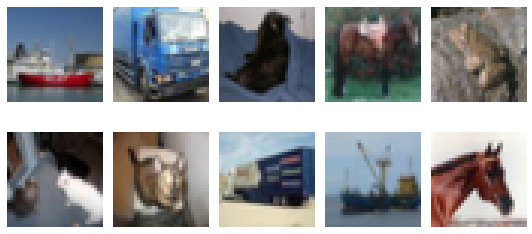

FGSM


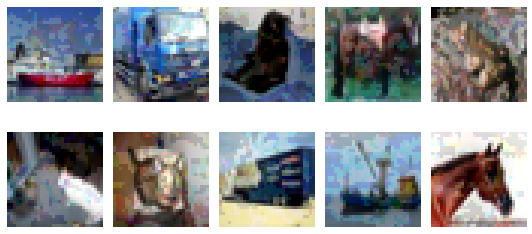

PGD-10


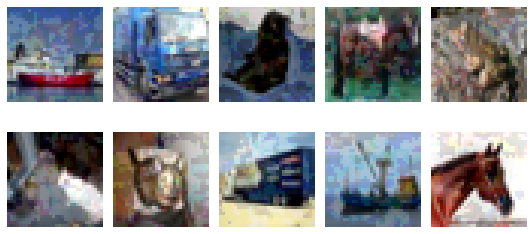

PGD-100


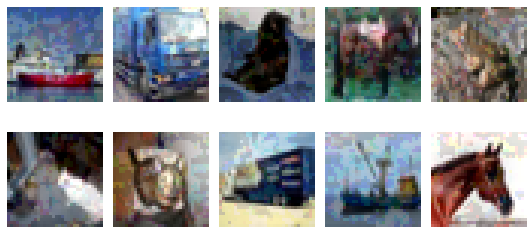

In [45]:
for idx, _x_train in enumerate(x_train_list):
    print("{:s}".format(attack_type[idx]))
    show_images(_x_train, shape)

In [46]:
for idx, _x_train in enumerate(x_train_list):
    print("{:s}".format(attack_type[idx]))
    ntk_train_train = kernel_list[1](_x_train, _x_train, 'ntk')[:4, :4]
    print(ntk_train_train)
    print()

Clean
[[30.82217759 13.98496226 12.30888758 13.81286374]
 [13.98496226 30.91200152 12.64773843 12.66519516]
 [12.30888758 12.64773843 30.75443008 13.79566112]
 [13.81286374 12.66519516 13.79566112 30.68698567]]

FGSM
[[30.83108819 13.19818281 11.54325492 12.82757624]
 [13.19818281 30.92601114 11.91187347 11.92818594]
 [11.54325492 11.91187347 30.76550774 12.56605686]
 [12.82757624 11.92818594 12.56605686 30.69559903]]

PGD-10
[[30.8271582  13.45983509 11.64334532 12.98623912]
 [13.45983509 30.92174343 12.23208536 12.18345152]
 [11.64334532 12.23208536 30.7623274  12.7577016 ]
 [12.98623912 12.18345152 12.7577016  30.69407815]]

PGD-100
[[30.82682194 13.47118277 11.65279106 12.99952858]
 [13.47118277 30.92138147 12.24670141 12.197885  ]
 [11.65279106 12.24670141 30.76222784 12.76820371]
 [12.99952858 12.197885   12.76820371 30.69396075]]



## Comparison with Exact NTK Training

In [47]:
def qc_map(W_var, b_var):
    W_std = np.sqrt(W_var)
    b_std = np.sqrt(b_var)

    # Create a single layer of a network as an affine transformation composed
    # with an Erf nonlinearity.
    kernel_fn = stax.serial(stax.Erf(), stax.Dense(1024, W_std, b_std))[2]
  
    def q_map_fn(q):
        return kernel_fn(Kernel(np.array([[q]]))).nngp[0, 0]
    qstar = fixed_point(q_map_fn, 1.0, 1e-7)

    def c_map_fn(c):
        K = np.array([[qstar, qstar * c], [qstar * c, qstar]])
        K_out = kernel_fn(Kernel(K)).nngp
        return K_out[1, 0] / qstar
    
    return q_map_fn, c_map_fn

c_map = lambda W_var, b_var: qc_map(W_var, b_var)[1]
q_map = lambda W_var, b_var: qc_map(W_var, b_var)[0]

q_star = lambda W_var, b_var: fixed_point(q_map(W_var, b_var), 1., 1e-7)
c_star = lambda W_var, b_var: fixed_point(c_map(W_var, b_var), 0.5, 1e-7)
chi = lambda c, W_var, b_var: grad(c_map(W_var, b_var))(c)
chi_1 = partial(chi, 1.)
chi_c = lambda W_var, b_var: grad(c_map(W_var, b_var))(c_star(W_var, b_var))

In [48]:
# Compute accuracies from predictions at different times.
@partial(vmap, in_axes=(0, None))
def _accuracy(predictions, labels):
    return np.mean(np.argmax(predictions, axis=-1) == np.argmax(labels, axis=-1))

@jit
# Run the experiment for different weight variances simultaneously.
@partial(vmap, in_axes=(0, None, None, None, None, None))
def experiment(W_var, b_var, layers, ts, x_train, x_test):
    W_std = np.sqrt(W_var)
    b_std = np.sqrt(b_var)

    dlayers = np.concatenate((layers[1:] - layers[:-1], np.array([0,])))

    input_to_kernel = partial(stax.Dense(1024)[2], get=('cov1', 'nngp', 'cov2', 'ntk'))
    kernel_fn = wrap(stax.serial(stax.Dense(1024, W_std, b_std), stax.Erf())[2])

    def body_fn(kernels, dlayer):
        kdd, ktd = kernels

        # Make predictions for the current set of kernels at all the different times.
        lambda_max = np.linalg.eigh(kdd.ntk)[0][-1]
        eta = y_train.size * 2. / lambda_max
        # eta = learning rate
        predict_fn = nt.predict.gradient_descent_mse(kdd.ntk, y_train, eta, diag_reg=diag_reg)
        # predict_fn = nt.predict.gradient_descent_mse(kdd.ntk, y_train, diag_reg=diag_reg)
        predict_fn = partial(predict_fn, fx_test_0=0., k_test_train=ktd.ntk)
        train, test = vmap(predict_fn)(ts)

        # Compute the next kernel after iterating the map for dlayers.
        kdd = lax.fori_loop(0, dlayer, lambda _, k: kernel_fn(k), kdd)
        ktd = lax.fori_loop(0, dlayer, lambda _, k: kernel_fn(k), ktd)

        return (kdd, ktd), (_accuracy(train, y_train), _accuracy(test, y_test), test)

    kdd = input_to_kernel(x_train, x_train)
    ktd = input_to_kernel(x_test, x_train)
    
    return lax.scan(body_fn, (kdd, ktd), dlayers)[1]

In [49]:
@partial(vmap, in_axes=(0, None))
def xi_1(W_var, b_var):
    # depth scale of trainability/generalization in the ordered phase.  
    return 1./ (np.abs(np.log(chi_1(W_var, b_var)))  + 1e-12 )

@partial(vmap, in_axes=(0, None))
def xi_star(W_var, b_var):
    # depth scale for generaliztion of NTK in the chaotic phase. 
    return 1. /(-np.log(chi_c(W_var, b_var)) + np.log(chi_1(W_var, b_var)))

In [50]:
train_acc_list = []
test_acc_list = []
xi_1s_list = []
xi_stars_list = []

for _x_train in x_train_list:
    # Experiment parameters.
    W_var = np.linspace(0.5, 3.0, 40)
    W_critical = 1.76
    b_var = 0.18
    
    dts = np.array([8**k for k in range(5)])
    dts = np.append(dts, np.inf)
    layers = np.array([i for i in range(10)] + [10 + 5*i for i in range(20)])

    # Train all of the infinite networks.
    train_acc, test_acc, test_pred = experiment(W_var, b_var, layers, dts, _x_train, x_test)

    # Rearrange the axes so they go [time, depth, weight_variance].
    train_acc = np.transpose(train_acc, (2, 1, 0))
    test_acc = np.transpose(test_acc, (2, 1, 0))

    # Compute the depth scales.
    W_ordered = np.array([W for W in W_var if W < W_critical])
    W_chaotic = np.array([W for W in W_var if W > W_critical]) 

    xi_1s = xi_1(W_ordered, b_var) 
    xi_stars = xi_star(W_chaotic, b_var) 
    
    # Append
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    xi_1s_list.append(xi_1s)
    xi_stars_list.append(xi_stars)

Type: Clean


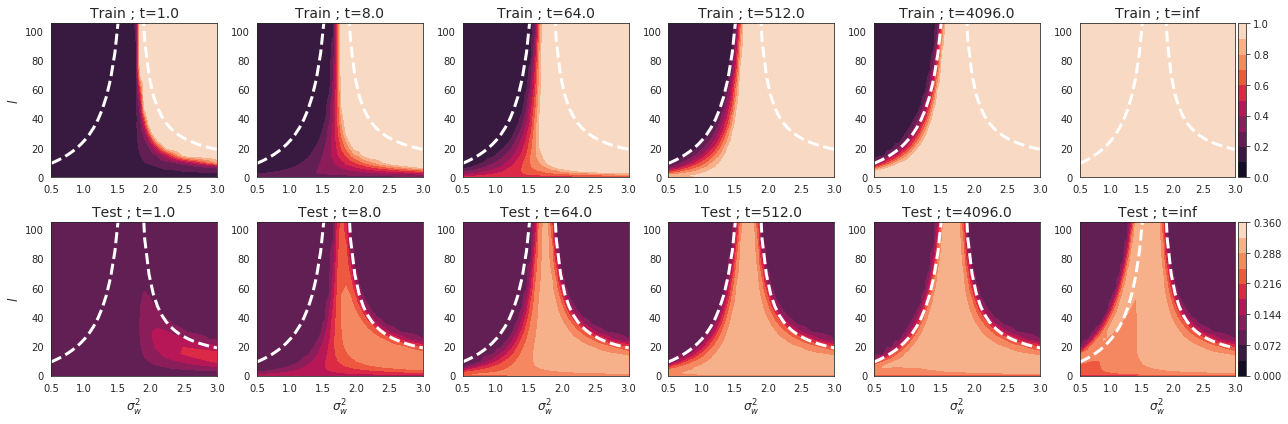

Type: FGSM


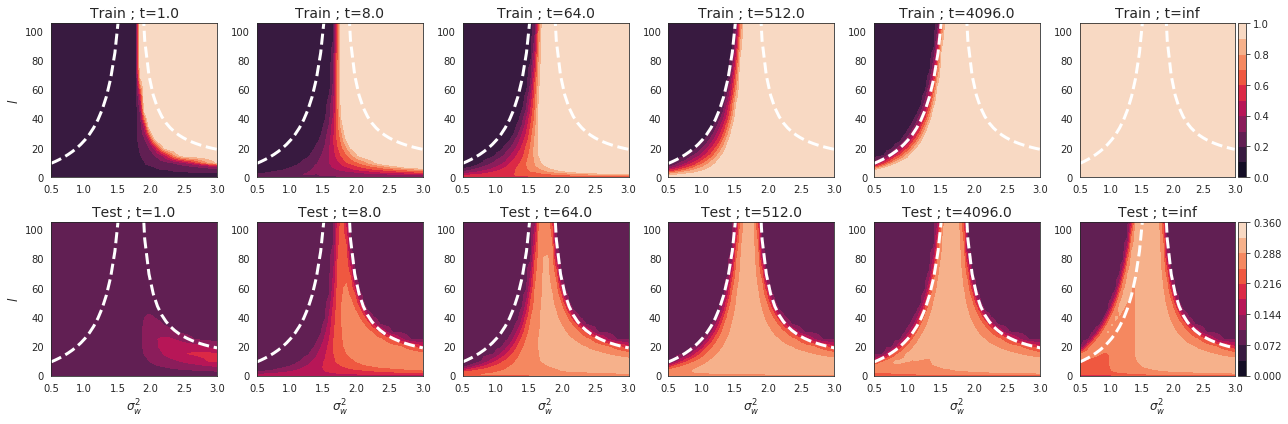

Type: PGD-10


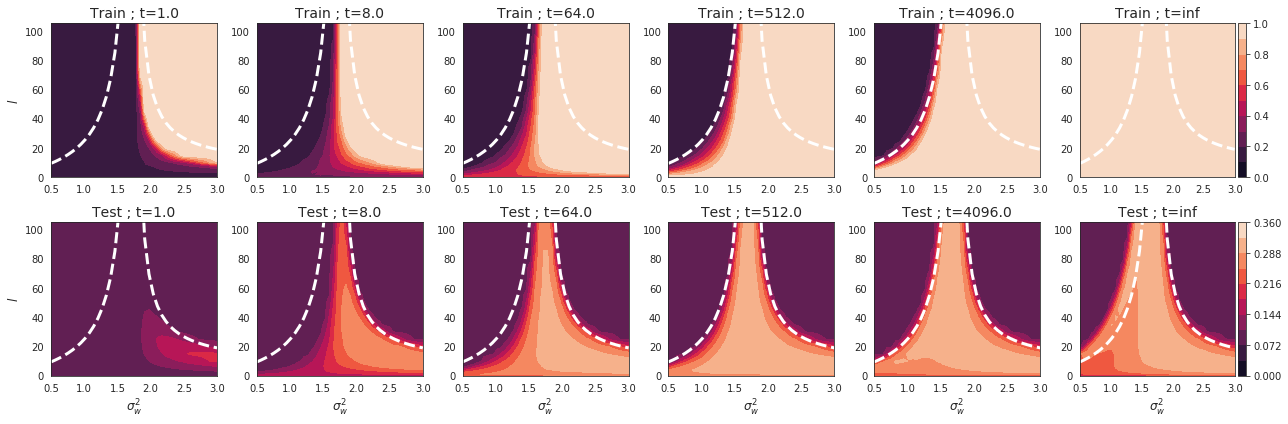

Type: PGD-100


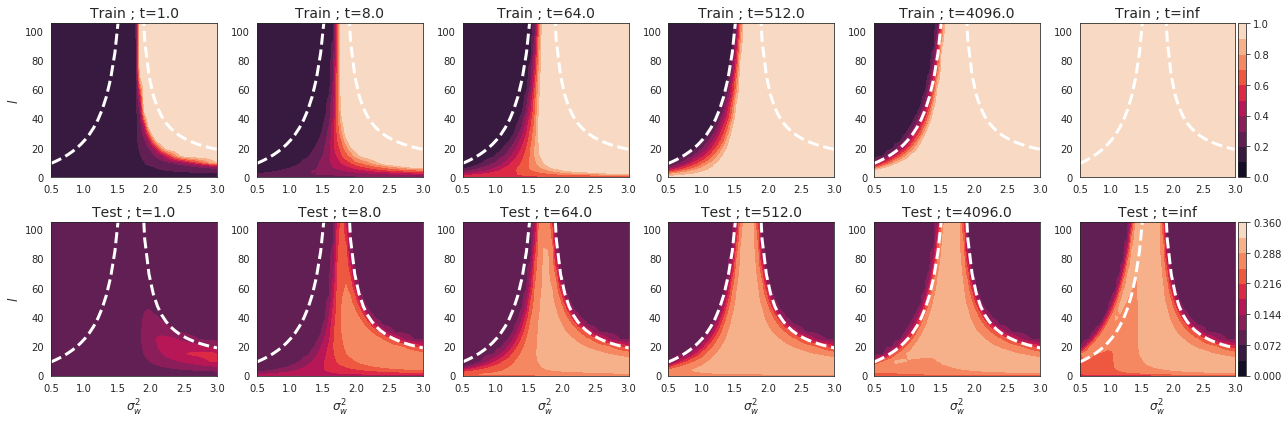

In [51]:
# un-normalized
ndts = len(dts)
train_levels = np.linspace(0, 1, 11)
test_levels = np.linspace(0, 0.36, 11)
depth_scaling = 8.

for a_type, train_acc, test_acc, xi_1s, xi_stars in zip(attack_type, train_acc_list, test_acc_list, xi_1s_list, xi_stars_list):
    print("Type:", a_type)
    
    for i, dt in enumerate(dts):
        plt.subplot(2, ndts, i + 1)
        im = plt.contourf(W_var, layers, train_acc[i], train_levels)
        plt.plot(W_ordered, depth_scaling * xi_1s, 'w--', linewidth=3)
        plt.plot(W_chaotic, depth_scaling * xi_stars, 'w--', linewidth=3)
        plt.title('Train ; t={}'.format(dt), fontsize=14)
        if i == 0:
            plt.ylabel('$l$', fontsize=12)
        plt.ylim([0, layers[-1]])
        if i == ndts - 1:
            cax = make_axes_locatable(plt.gca()).append_axes('right', size='5%', pad=0.05)
            plt.colorbar(im, cax=cax)

        plt.subplot(2, ndts, ndts + i + 1)
        im = plt.contourf(W_var, layers, test_acc[i], test_levels)
        plt.title('Test ; t={}'.format(dt), fontsize=14)
        plt.plot(W_ordered, depth_scaling * xi_1s, 'w--', linewidth=3)
        plt.plot(W_chaotic, depth_scaling * xi_stars, 'w--', linewidth=3)
        plt.xlabel('$\\sigma_w^2$', fontsize=12)
        if i == 0:
            plt.ylabel('$l$', fontsize=12)
        plt.ylim([0, layers[-1]])
        if i == ndts - 1:
            cax = make_axes_locatable(plt.gca()).append_axes('right', size='5%', pad=0.05)
            plt.colorbar(im, cax=cax)

    finalize_plot((ndts / 2, 1.))
    plt.show()

In [52]:
l = 50
phase ={"ordered": 8,
        "critical": 20, 
        "chaotic": 32}

print("T = 1 / 8 / 64 / 512 / 4096 / inf")
for a_type, train_acc, test_acc in zip(attack_type, train_acc_list, test_acc_list):
    print(a_type)
    for k, v in phase.items():
        print(k)
        # Train
        _acc = np.reshape(train_acc[:, [np.where(layers==l)[0][0]], v], 6)
        print("Train Acc\n{:.2f} / {:.2f} / {:.2f} / {:.2f} / {:.2f} / {:.2f}".format(_acc[0], _acc[1], _acc[2], 
                                                                                      _acc[3], _acc[4], _acc[5]))

        # Test
        _acc = np.reshape(test_acc[:, [np.where(layers==l)[0][0]], v], 6)
        print("Test Acc\n{:.2f} / {:.2f} / {:.2f} / {:.2f} / {:.2f} / {:.2f}".format(_acc[0], _acc[1], _acc[2],
                                                                                     _acc[3], _acc[4], _acc[5]))
    print()

T = 1 / 8 / 64 / 512 / 4096 / inf
Clean
ordered
Train Acc
0.16 / 0.16 / 0.16 / 0.16 / 0.16 / 1.00
Test Acc
0.10 / 0.10 / 0.10 / 0.10 / 0.10 / 0.12
critical
Train Acc
0.18 / 0.91 / 1.00 / 1.00 / 1.00 / 1.00
Test Acc
0.10 / 0.25 / 0.31 / 0.31 / 0.31 / 0.31
chaotic
Train Acc
1.00 / 1.00 / 1.00 / 1.00 / 1.00 / 1.00
Test Acc
0.10 / 0.10 / 0.10 / 0.10 / 0.10 / 0.10

FGSM
ordered
Train Acc
0.16 / 0.16 / 0.16 / 0.16 / 0.16 / 1.00
Test Acc
0.10 / 0.10 / 0.10 / 0.10 / 0.10 / 0.12
critical
Train Acc
0.16 / 0.96 / 1.00 / 1.00 / 1.00 / 1.00
Test Acc
0.10 / 0.25 / 0.30 / 0.31 / 0.31 / 0.31
chaotic
Train Acc
1.00 / 1.00 / 1.00 / 1.00 / 1.00 / 1.00
Test Acc
0.10 / 0.10 / 0.10 / 0.10 / 0.10 / 0.10

PGD-10
ordered
Train Acc
0.16 / 0.16 / 0.16 / 0.16 / 0.16 / 1.00
Test Acc
0.10 / 0.10 / 0.10 / 0.10 / 0.10 / 0.12
critical
Train Acc
0.18 / 0.95 / 1.00 / 1.00 / 1.00 / 1.00
Test Acc
0.10 / 0.25 / 0.30 / 0.31 / 0.31 / 0.31
chaotic
Train Acc
1.00 / 1.00 / 1.00 / 1.00 / 1.00 / 1.00
Test Acc
0.10 / 0.10 / 0.10 /

## Spectrum of NTK and Mean Predictor

In [53]:
def ntk(W_var, b_var, layers):
    W_std, b_std = map(np.sqrt, (W_var, b_var))
    
    # Helper function to create a kernel out of inputs.
    readin_fn = partial(stax.Dense(1024, 1.0, 0.0)[2], get=('cov1', 'nngp', 'cov2', 'ntk'))
    
    # Function to compute the NTK after a single layer of the network. 
    _layer_fn = wrap(stax.serial(stax.Erf(), stax.Dense(1024, W_std, b_std))[2])
    layer_fn = lambda Theta_l, l: (_layer_fn(Theta_l), Theta_l.ntk)  

    return jit(lambda X1, X2: lax.scan(layer_fn, readin_fn(X1, X2), layers)[1])

@jit
def spectral_info(kernels):
    @vmap
    def spectral_fn(kernel):
        evals = np.linalg.eigh(kernel)[0]
        return evals[0], evals[-1], evals[-1] / evals[0]
    return spectral_fn(kernels)

def mean_predictor(ntk_fn, x_train, y_train, x_test, reg=0.):
    ktd = ntk_fn(x_test, x_train)
    kdd = ntk_fn(x_train, x_train)
    @vmap
    def inv(k):
        return np.linalg.inv(k + reg * np.eye(k.shape[0]))
    return np.einsum('ijk,ikl,lm->ijm', ktd, inv(kdd), y_train)

In [54]:
b = 0.18
W_ordered = 1.25
W_chaotic = 1.5
W_critical = 1.76
layers = np.arange(400)
nlayers = len(layers)

W = W_critical

# params = {"font.size": 18, 
#           "figure.titlesize": 40, 
#           "axes.titlesize": 26}
plt.rcParams.update({"font.size": 18})

In [55]:
theta_list = []
for idx, _x_train in enumerate(x_train_list):
    theta_list.append(ntk(W, b, layers)(_x_train, _x_train))

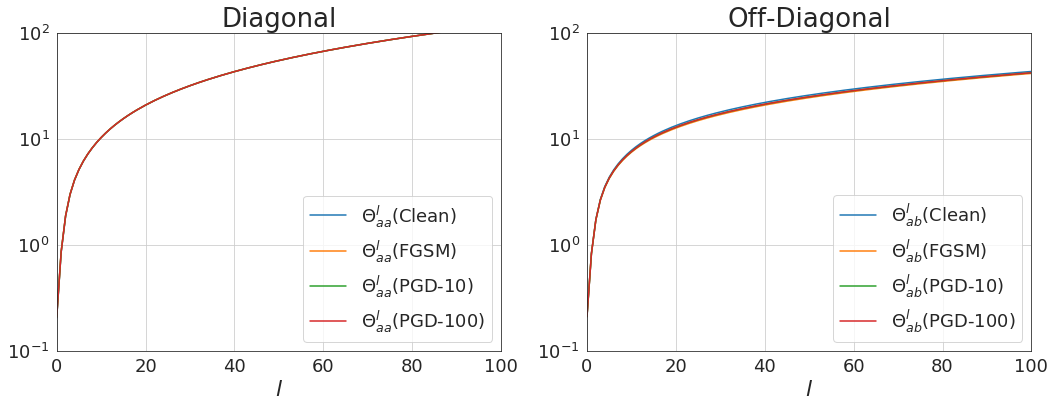

In [56]:
plt.subplot(1, 2, 1)
# Plot the diagonal term against \chi_1.
for idx, theta in enumerate(theta_list):
    plt.semilogy(theta[:, 0, 0], color=colors[idx], 
                 label='$\\Theta^l_{aa}$'+'({:s})'.format(attack_type[idx]))
# plt.semilogy(scale(chi_1(W, b) ** layers, theta[:, 0, 0]), 'k--', label='$\\chi_1^l$')
plt.ylim([10 ** -1, 10 ** 2])
plt.xlim([0, 100])
plt.legend()
format_plot('Diagonal', '$l$')

plt.subplot(1, 2, 2)
# Plot the off-diagonal term against q*c* / (1 - chi_c*).
for idx, theta in enumerate(theta_list):
    plt.semilogy(theta[:, 0, 1], color=colors[idx], 
                 label='$\\Theta^l_{ab}$'+'({:s})'.format(attack_type[idx]))
p_star = q_star(W, b) * c_star(W, b) / (1 - chi_c(W, b))
# plt.semilogy([layers[0], layers[-1]], [p_star, p_star], 'k--', label='$\\frac{q^*c^*}{1 - \\chi_{c^*}}$')
plt.ylim([10 ** -1, 10 ** 2])
plt.xlim([0, 100])
plt.legend()
format_plot('Off-Diagonal', '$l$')
finalize_plot((2.5, 1))

In [57]:
spectral_list = []
for theta in theta_list:
    spectral_list.append(spectral_info(theta))

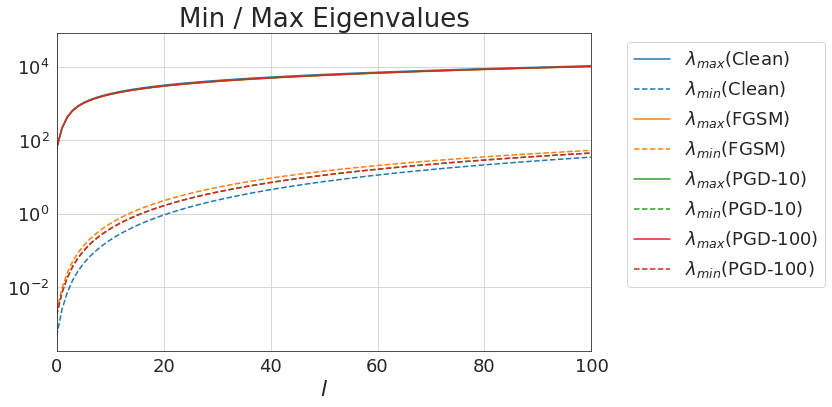

In [58]:
for idx, (lambda_min, lambda_max, _) in enumerate(spectral_list):
#     if idx == 0 or idx == 3:
    plt.semilogy(lambda_max, color=colors[idx], 
                 label='$\\lambda_{max}$'+'({:s})'.format(attack_type[idx]))
    plt.semilogy(lambda_min, linestyle='--', color=colors[idx], 
                 label='$\\lambda_{min}$'+'({:s})'.format(attack_type[idx]))
plt.xlim([0, 100])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
format_plot('Min / Max Eigenvalues', '$l$')
finalize_plot((2, 1))

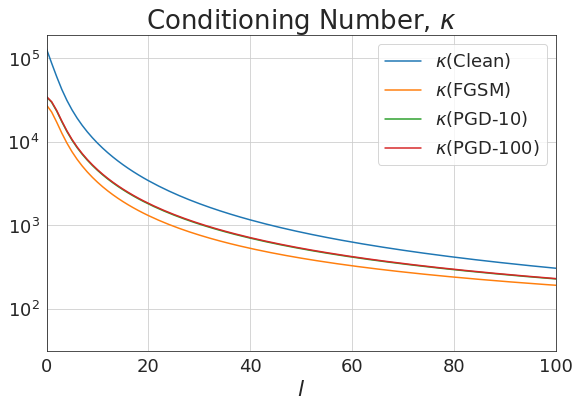

In [59]:
for idx, (_, _, kappa) in enumerate(spectral_list):
    plt.semilogy(kappa, label='$\\kappa$'+'({:s})'.format(attack_type[idx]))
# plt.ylim([10 ** -1, 10 ** 2])
plt.xlim([0, 100])
plt.legend()
format_plot('Conditioning Number, $\\kappa$', '$l$')
finalize_plot((1.4, 1))

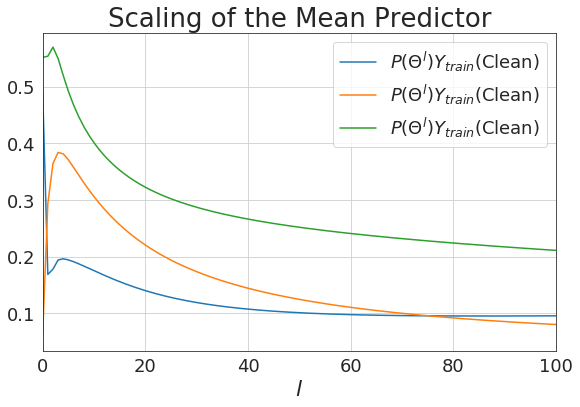

In [76]:
for idx, _x_train in enumerate(x_train_list):
    delta = mean_predictor(ntk(W, b, layers), x_train, y_train, x_test[:3000])
    plt.plot(np.abs(delta[:, 0, 7]), label='$P(\\Theta^l)Y_{train}$'+'({:s})'.format(attack_type[idx]))
    plt.plot(np.abs(delta[:, 1, 0]), label='$P(\\Theta^l)Y_{train}$'+'({:s})'.format(attack_type[idx]))
    plt.plot(np.abs(delta[:, 2, 6]), label='$P(\\Theta^l)Y_{train}$'+'({:s})'.format(attack_type[idx]))
    break
plt.xlim([0, 100])
# plt.ylim([0, 0.2])
plt.legend()

format_plot('Scaling of the Mean Predictor', '$l$')
finalize_plot((1.4, 1))

In [35]:
x_train_list.pop(0)

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

In [36]:
x_train_list = np.asarray(x_train_list)
np.save('./dataset/train_matrix_ordered.npy', x_train_list)